# Imports

In [1]:
import sklearn.svm
import sklearn.neural_network
import sklearn.tree
import sklearn.ensemble
import sklearn.svm
import sklearn.neural_network

import wasmshield.evaluator.malware_wobfuscated
import wasmshield.training.trainer
import wasmshield.preprocessing
import warnings
import sklearn.exceptions
import wasmshield.training.trainer
import wasmshield.models.resbin

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=sklearn.exceptions.UndefinedMetricWarning)

device = 'mps'

/opt/homebrew/Caskroom/miniforge/base/envs/datascience/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
2024-05-12 00:28:10.033056: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-12 00:28:10.033495: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import catboost

# Loading evaluator

In [3]:
malware_wobfuscated_evaluator = wasmshield.evaluator.malware_wobfuscated.MalwareWobfuscatedEvaluator()

# Loading models

In [4]:

import wasmshield.training.trainer
import wasmshield.models.resbin
from wasmshield.models.resbin import *

model_name_18 = 'Emprique60_2_ResBin18_b64_i64_pil_v128_rmax_t015'
trainable_model_18 = wasmshield.training.trainer.TrainableModel(model=None, name=model_name_18, device=device)
resbin_18_sa = wasmshield.models.resbin.ResBinHandler(
    trainable_model_18.model.backbone
)

model_name_8 = 'Emprique60_2_ResBin8_b64_i64_pil_v128_rmax_t015'
trainable_model_8 = wasmshield.training.trainer.TrainableModel(model=None, name=model_name_8, device=device)
resbin_8_sa = wasmshield.models.resbin.ResBinHandler(
    trainable_model_8.model.backbone
)

model_name_18_woSA= 'Emprique60_2_ResBin18_woSA_b64_i64_pil_v128_rmax_t015'
trainable_model_18_woSA = wasmshield.training.trainer.TrainableModel(model=None, name=model_name_18_woSA, device=device)
resbin_18 = wasmshield.models.resbin.ResBinHandler(
    trainable_model_18_woSA.model.backbone
)

model_name_8_woSA = 'Emprique60_2_ResBin8_woSA_b64_i64_pil_v128_rmax_t015'
trainable_model_8_woSA = wasmshield.training.trainer.TrainableModel(
    model=None, 
    name=model_name_8_woSA, 
    device=device
)
resbin_8 = wasmshield.models.resbin.ResBinHandler(
    trainable_model_8_woSA.model.backbone
)

import wasmshield.approaches.jabberwock
from gensim.models import Doc2Vec

doc2vec = Doc2Vec.load('models/doc2vec_js.model')


Attempting to load model_name=Emprique60_2_ResBin18_b64_i64_pil_v128_rmax_t015
Attempting to load model_name=Emprique60_2_ResBin8_b64_i64_pil_v128_rmax_t015
Attempting to load model_name=Emprique60_2_ResBin18_woSA_b64_i64_pil_v128_rmax_t015
Attempting to load model_name=Emprique60_2_ResBin8_woSA_b64_i64_pil_v128_rmax_t015


# Loading classifiers

In [5]:
from wasmshield.models.base_classifier import BaseClassifier, SklearnClassifier
import wasmshield.approaches.minos
import wasmshield.approaches.jabberwock
import wasmshield.models.resbin

sklearn_model_loaders = [
    (
        'CatBoost',
        lambda : catboost.CatBoostClassifier(n_estimators=2000,verbose=False,eval_metric='TotalF1',eval_fraction=0.2),
    ),
]

jb_handler = lambda d : (
    wasmshield.approaches.jabberwock.JabberWockHandler(
        d, 
        save_vectors_in="/Volumes/Walid-SSD/ESI/PFE/DATASETS/jabberwock_js_vectors_128/",
    )
)

handlers = [
        (
        'JabberWock', 
        jb_handler,
        doc2vec,
    ),
    (
        'ResBin8', 
        wasmshield.models.resbin.ResBinHandler, 
        trainable_model_8_woSA.model.backbone
    ),
    (
        'ResBin18', 
        wasmshield.models.resbin.ResBinHandler, 
        trainable_model_18_woSA.model.backbone
    ),
    (
        'ResBin8-SA', 
        wasmshield.models.resbin.ResBinHandler, 
        trainable_model_8.model.backbone
    ),
    (
        'ResBin18-SA', 
        wasmshield.models.resbin.ResBinHandler, 
        trainable_model_18.model.backbone
    ),
]

model_names:list[str] = []
classifiers:list[BaseClassifier] = []

for cls_name, cls_model_loader in sklearn_model_loaders:
    for handler_name, handler, model in handlers:
        model_names.append(
            f'{handler_name}+{cls_name}'
        )
        classifiers.append(
            SklearnClassifier(
                handler_cls=handler,
                model=model,
                classifier_model=cls_model_loader()
            ),
        )

minos_model = wasmshield.approaches.minos.build_minos_cnn(num_classes=len(np.unique(malware_wobfuscated_evaluator.y_train)))
minos_classifier = wasmshield.approaches.minos.MinosClassifier(
    minos_model,
)
model_names.append('MINOS')
classifiers.append(minos_classifier)


# Training

In [10]:
all_dict = {}
all_dict['classifiers'] = classifiers
all_dict['model_names'] = model_names

In [11]:
all_dict.update(malware_wobfuscated_evaluator.train_many_models(classifier_models=classifiers))

(227798, 10000) (227798, 2)
Epoch 1/20


2024-05-12 01:02:57.632541: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-05-12 01:02:58.433233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7119/7119 [==============================] - 150s 21ms/step - loss: 0.3102 - accuracy: 0.9018
Epoch 2/20
7119/7119 [==============================] - 149s 21ms/step - loss: 0.2515 - accuracy: 0.9170
Epoch 3/20
7119/7119 [==============================] - 150s 21ms/step - loss: 0.2785 - accuracy: 0.9093
Epoch 4/20
7119/7119 [==============================] - 150s 21ms/step - loss: 0.2991 - accuracy: 0.9010
Epoch 5/20
7119/7119 [==============================] - 150s 21ms/step - loss: 0.3609 - accuracy: 0.8993
Epoch 6/20
7119/7119 [==============================] - 150s 21ms/step - loss: 0.3477 - accuracy: 0.8987
Epoch 7/20
7119/7119 [==============================] - 150s 21ms/step - loss: 0.3498 - accuracy: 0.8932
Epoch 8/20
7119/7119 [==============================] - 152s 21ms/step - loss: 0.3551 - accuracy: 0.8939
Epoch 9/20
7119/7119 [==============================] - 152s 21ms/step - loss: 0.3541 - accuracy: 0.8981
Epoch 10/20
7119/7119 [==============================] - 152s 21ms

# Evaluation

In [12]:
all_dict.update(malware_wobfuscated_evaluator.eval_many_models(classifier_models=classifiers))

2024-05-12 01:59:54.153870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


# Results

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.patheffects as pe
plt.style.use('default')
plt.rcParams["axes.grid"] = True

mapper = {
      'ResBin8':0,
      'ResBin8-SA':1,
      'ResBin18':2,
      'ResBin18-SA':3,
      'ResBin18-SA-TL':6,
      'JabberWock':4,
      'MINOS':5,
}

pos_mapper = {
      'JabberWock':0,
      'ResBin8':0,
      'ResBin8-SA':0,
      'ResBin18':10,
      'ResBin18-SA':10,
      'ResBin18-SA-TL':10,
      'MINOS':0,
}

colors = [
      '#fdcc8a',#R8
      '#fc8d59',#R8SA
      '#ff6361',#R18
      '#d7301f',#R18SA
      '#ffa600', #JW
      '#00c6ff',#MINOS
      '#2E7D32',#R18SA-TL
]

def plot_bar(df:pd.DataFrame, x, y, hue, ax, xlabel):

      group = df[x].tolist()
    
      alg = df[hue].tolist()
      
      alg_colors = [colors[mapper[c]] for c in alg]

      results = df[y].tolist()
      model_names = df['model_name'].tolist()

      dist_groups = 0.4 
      pos = (np.array([0] + [g1 != g2 for g1, g2 in zip(group[:-1], group[1:])]) * dist_groups + 1).cumsum()
      labels = [g1 for g1, g2 in zip(group[:-1], group[1:]) if g1 != g2] + group[-1:]
      label_pos = [
            sum([p for g, p in zip(group, pos) if g == label]) / len([1 for g in group if g == label])  
            for idx,label in enumerate(labels)
      ]
      
      bars = ax.bar(
            pos, 
            results, 
            color=alg_colors, 
            label=df['model_name'],
            width=1,
            edgecolor = "black",
      )
      ax.set_xticks(label_pos, labels)

      _patterns=["|" , "O", "\\" , '*' ,  'x', ".", "-", "/", "+" ]

      for idx, i in enumerate(bars.patches):
            i.set_hatch(_patterns[mapper[i.get_label()]%len(_patterns)])
            
      ax.legend().remove()

      ax.set_ylabel(y,fontsize=16)
      ax.set_xlabel(xlabel,fontsize=16)
      ax.margins(x=0.04)
      ax.tick_params(axis='x', labelsize=16)
      ax.tick_params(axis='y', labelsize=16)

      fmt='%.4f'
      barlabels = ax.bar_label(
           bars, fmt=fmt, 
           path_effects=[pe.withStroke(linewidth=3, foreground="white"), ], 
           weight='bold', fontsize=14,
      )
      
      [barlabels[i].set_y(pos_mapper[bars.patches[i].get_label()]) for i in range(len(barlabels))]

def plot_barplot(plot_df, xlabel):

      fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,4), facecolor='white')
      fig.tight_layout(pad=2, w_pad=3)
      ax = axes[0]
      plot_bar(plot_df, x='classifier', y='F1-Score', hue='model_name', ax=ax, xlabel=xlabel )
      ax = axes[1]
      plot_bar(plot_df, x='classifier', y='Accuracy', hue='model_name', ax=ax, xlabel=xlabel )

      lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
      lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

      unique_labels = plot_df['model_name'].unique()
      legend_dict = dict(zip(labels, lines))
      unique_lines = [legend_dict[x] for x in unique_labels]

      fig.legend(
            unique_lines, 
            unique_labels,
            loc='upper center', 
            bbox_to_anchor=(0.5,0),
            fancybox=True, 
            shadow=True, 
            ncol=6,
            fontsize=12,
      )

import pandas as pd

records = []
for idx, row in pd.DataFrame.from_dict(all_dict).iterrows():
    model_name = row['model_names']
    if model_name == "MINOS":
        model_name, classifier_name = model_name, 'MLP'
    else:
        model_name, classifier_name = model_name.split('+')
    records.append({
        'model_name' : model_name,
        'classifier' : classifier_name,
        'F1-Score': row['overall_results_list']['weighted avg']['f1-score'],
        'Accuracy': row['overall_results_list']['accuracy'],
    })

plot_df = pd.DataFrame.from_records(records)

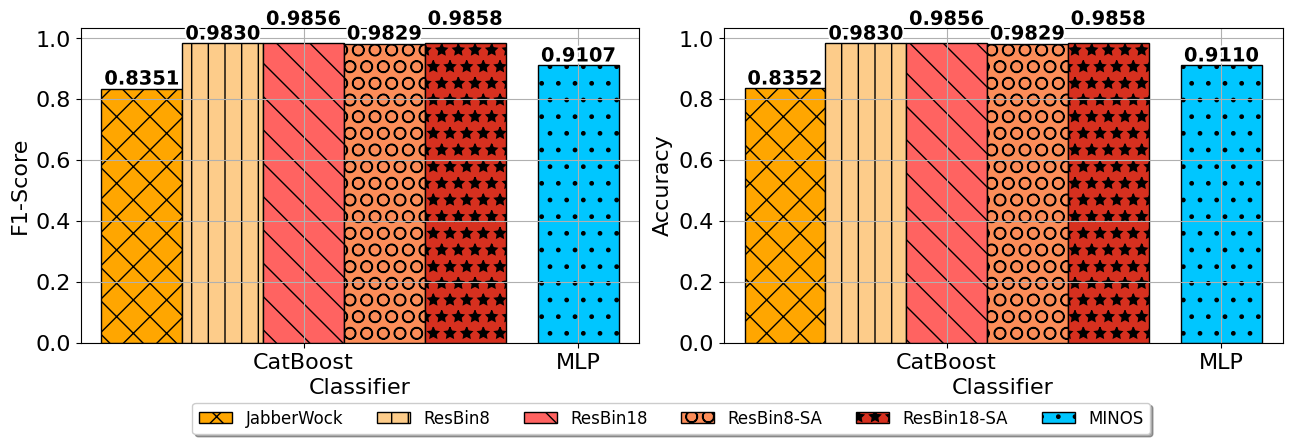

In [24]:
plot_barplot(plot_df, xlabel='Classifier')